In [1]:
# Do we need to train the discriminator and generator?
# or just load the weights?
TRAIN_DISCRIMINATOR = False
TRAIN_GENERATOR = True
WGAN = False
TARGET_DIGIT = 8
MUTATE_POOL = True
LOSS_TYPE = 'l2'

iters_lower, iters_upper = 120, 121


In [2]:
#@title imports and notebook utils

import time
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import imageio
import random



import tensorflow as tf

from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential, backend
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
from keras.initializers import RandomNormal

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    if len(img.shape) == 3 and img.shape[-1] == 4:
      img = img[..., :3] * img[..., 3, None]
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [3]:
# Do we need to train the discriminator and generator?
# or just load the weights?
TRAIN_DISCRIMINATOR = False
TRAIN_GENERATOR = False
WGAN = False
TARGET_DIGIT = 8
MUTATE_POOL = True
LOSS_TYPE = 'l2'

iters_lower, iters_upper = 120, 121


In [4]:
#@title imports and notebook utils

import time
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import imageio
import random



import tensorflow as tf

from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential, backend
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
from keras.initializers import RandomNormal

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    if len(img.shape) == 3 and img.shape[-1] == 4:
      img = img[..., :3] * img[..., 3, None]
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

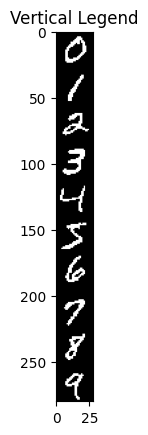

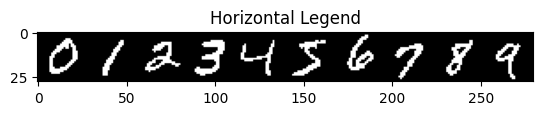

In [5]:
# @title Generate train/test set from MNIST.

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = 1 * ((train_images) / 255)

target_images = []
for digit in range(10):
    index = np.where(train_labels == digit)[0][0]
    image = train_images[index]
    target_images.append(image)

target_images = np.array(target_images)
rounded_target_images = np.where(target_images > 0.5, 1.0, 0.0)


BUFFER_SIZE = 60000
BATCH_SIZE = 256


def to_ten_dim_label(x, y):
    # x shape is [b, r, c]
    # y shape is [b]
    y_res = np.zeros(list(x.shape) + [10])
    y_expanded = np.broadcast_to(y, x.T.shape).T
    y_res[x >= 0.1, y_expanded[x >= 0.1]] = 1.0
    return y_res.astype(np.float32)

y_train_pic = to_ten_dim_label(train_images, train_labels)

def find_bw_legend(x_set, y_set, orientation="vertical"):
    result_x = rounded_target_images.copy()

    if orientation == "vertical":
        result_x = np.concatenate(result_x, axis=0)
    else:
        result_x = np.concatenate(result_x, axis=1)

    return result_x

# Create vertical and horizontal black and white legends
bw_legend_vertical = find_bw_legend(train_images, train_labels, orientation="vertical")
bw_legend_horizontal = find_bw_legend(train_images, train_labels, orientation="horizontal")

# Show the legend using matplotlib or some other library of your choice
import matplotlib.pyplot as plt

plt.imshow(bw_legend_vertical, cmap='gray')
plt.title('Vertical Legend')
plt.show()

plt.imshow(bw_legend_horizontal, cmap='gray')
plt.title('Horizontal Legend')
plt.show()


In [6]:
CHANNEL_N = 16 # Number of CA state channels
CELL_FIRE_RATE = 0.5

In [7]:
#@title CA model and utils
def to_greyscale(x):
    return tf.clip_by_value(x[..., 0:1], 0.0, 1.0)

def get_living_mask(x):
    alpha = x[:, :, :, 0:1]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

class CustomInitializer(Initializer):
    def __init__(self, mean=0.0, stddev=0.01):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, shape, dtype=np.float32):
        return tf.random.normal(shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

In [8]:
class build_generator(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE, l2_reg = 0):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        self.custom_init = CustomInitializer(mean=0) #was 0.008

        self.perceive = tf.keras.Sequential([
            Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
        ])

        self.dmodel = tf.keras.Sequential([
            Conv2D(80, 1, activation=tf.nn.relu, kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
            Conv2D(self.channel_n, 1, activation=None,
                kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
        ])

        self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

    def reinitialize_weights(self):
        for layer in self.dmodel.layers:
            if hasattr(layer, 'kernel_initializer'):
                layer.kernel.assign(self.custom_init(layer.kernel.shape))
            if hasattr(layer, 'bias_initializer') and layer.use_bias:
                layer.bias.assign(self.custom_init(layer.bias.shape))

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        pre_life_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y)*step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

        return x * tf.cast(life_mask, tf.float32)


build_generator().dmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (1, 3, 3, 80)             6480      
                                                                 
 conv2d_2 (Conv2D)           (1, 3, 3, 16)             1296      
                                                                 
Total params: 7776 (30.38 KB)
Trainable params: 7776 (30.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


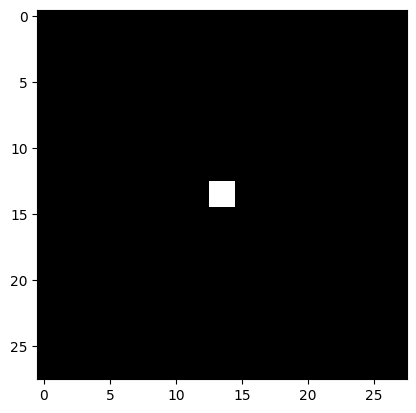

In [9]:
#@title Lets generate an image! (basic testing that the generator works, with animation)
def make_seed():
    h, w = 28, 28
    seeds = np.zeros([10, h, w, CHANNEL_N], np.float32)
    for n in range(10):
        for j in range(h//2 - 1, h//2 + 1):
            for k in range(w//2 - 1, w//2 + 1):
                np.put(seeds[n, j, k], [0, 1 + n], 1)
    return seeds


generator = build_generator()

def animate_ca(generator, h=1, w=1):
    x = make_seed()

    for i in range(1):
        x = generator(x, training=False)
        plt.imshow(to_greyscale(x)[0, :, :, 0], cmap='gray')
        plt.show()
    return x

x = animate_ca(generator)

In [10]:

#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72)
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None]
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    print("working")
    x = test_input

    iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)

    for i in tf.range(iter_n):
        x = model(x)

    predictions = x

    print("Iters: ", iter_n)
    print(predictions.shape)

    # Loop over each image in predictions
    for i in range(predictions.shape[0]):
        plt.imshow(to_greyscale(predictions)[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.savefig('image_at_epoch_{:04d}_{}.png'.format(epoch, i))
        plt.show()

    print(x.shape)

    return to_greyscale(predictions)[0, :, :, 0]


Train the generator

In [11]:
#@title Reimplement the original training architechture to learn a single exact digit!

#@title Initialize Training { vertical-output: true}

h = 28
w = 28

seeds = make_seed()

print(seeds.shape)

def loss_f(output, label):
  return tf.reduce_mean(tf.square(to_greyscale(output)-rounded_target_images[label]), [-2, -3, -1])

ca = build_generator()

loss_log = []

lr = 2e-4
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.legacy.Adam(lr_sched)

loss0 = loss_f(seeds, range(10)).numpy()

!mkdir -p train_log && rm -f train_log/*

(10, 28, 28, 16)


zsh:1: no matches found: train_log/*


working
Iters:  tf.Tensor(120, shape=(), dtype=int32)
(10, 28, 28, 16)


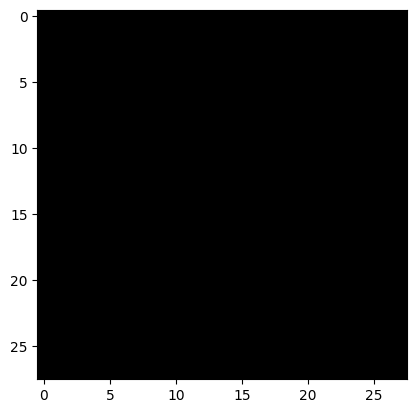

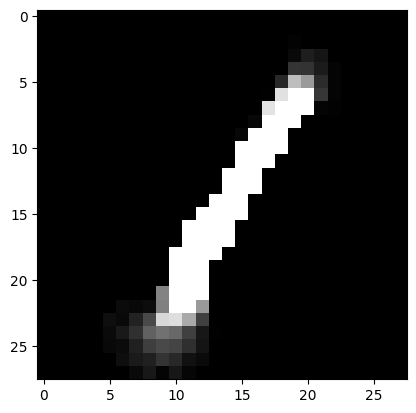

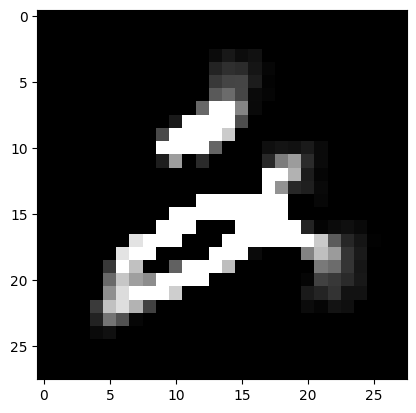

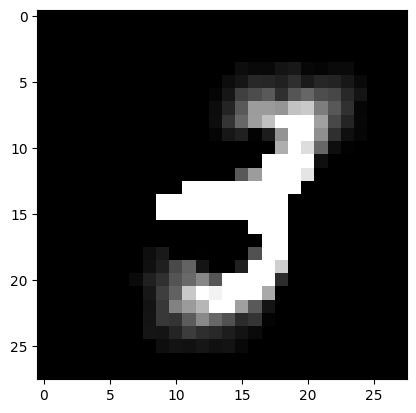

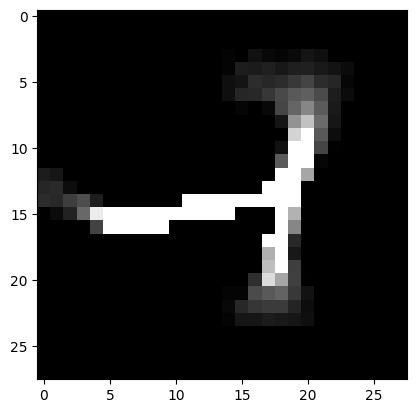

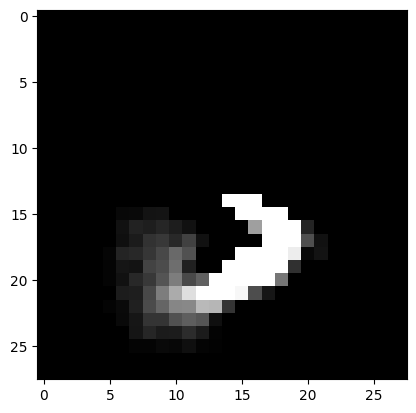

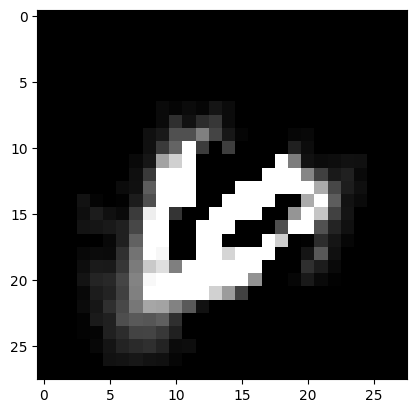

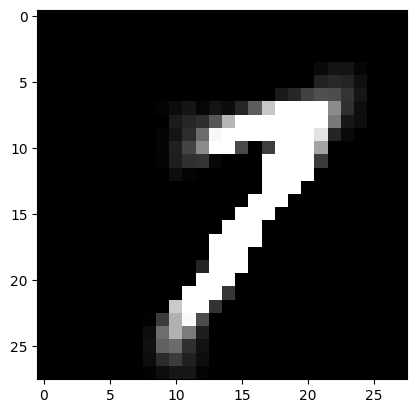

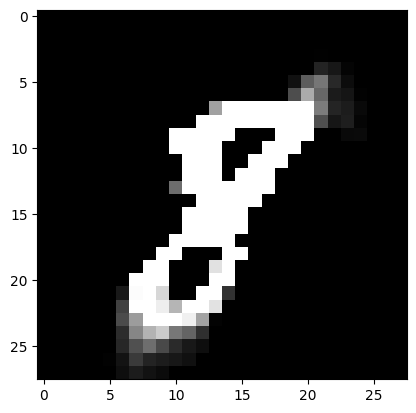

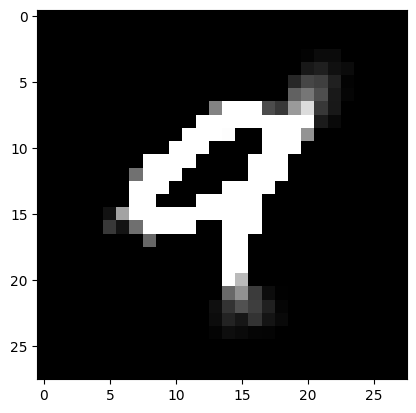

(10, 28, 28, 16)
Epoch 4001, Loss: 0.0517


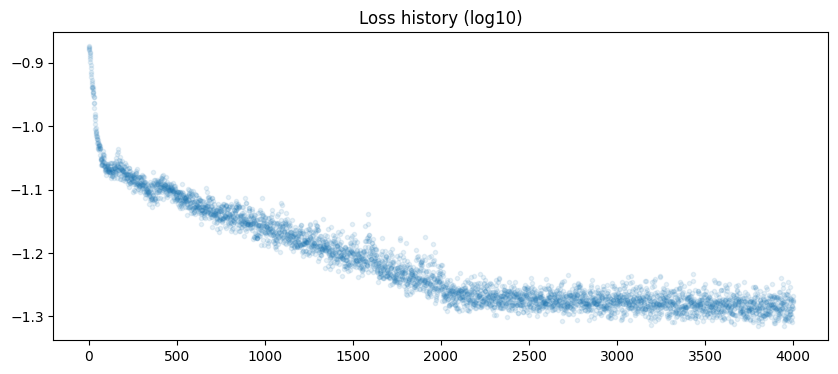

 step: 4001, log10(loss): -1.286

In [12]:
#@title Original Training Loop {vertical-output: false}

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()

@tf.function
def train_step(x):
  iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x, range(10)))
    reg_losses = tf.add_n(ca.dmodel.losses)
    total_loss = loss + reg_losses
  grads = g.gradient(total_loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, total_loss


for i in range(4000+1):

    x0 = seeds.copy()

    x, loss = train_step(x0)

    step_i = len(loss_log)
    loss_log.append(loss.numpy())

    if step_i%100 == 0:
        clear_output(wait=True)
        generate_and_save_images(ca,
                                step_i + 1,
                                x0)
        # if tf.reduce_all(generate_and_save_images(ca,
        #                         i + 1,
        #                         x0) == 0.0): 
        #     ca.reinitialize_weights() # restart training if the model collapses
        # Print the losses
        print(f"Epoch {i + 1}, Loss: {loss:.4f}")
        plot_loss(loss_log)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

In [13]:
# Get the weights of the first layer
weights = ca.dmodel.layers[0].weights[0].numpy()

# Normalize the weights to range 0-1 for visualization
weights_min = weights.min()
weights_max = weights.max()

print(weights_min, weights_max)

-0.11748256 0.116140865


In [14]:
if TRAIN_GENERATOR: 
  ca.save_weights(f"ca_{TARGET_DIGIT}.h5")

In [15]:
ca.load_weights(f"ca_{TARGET_DIGIT}.h5")

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

NameError: name 'generator_optimizer' is not defined

In [ ]:
def print_image_sample(images): 
    plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

def noisify(images, noise_factor):

    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise
    # Clip the values to be between 0 and 1
    noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0.0, clip_value_max=1.0)
    return noisy_images


In [ ]:
def add_noise_to_weights(model, noise_level=0.01):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Check if the layer has weights
            noisy_weights = [w + noise_level * np.random.randn(*w.shape) for w in weights]
            layer.set_weights(noisy_weights)

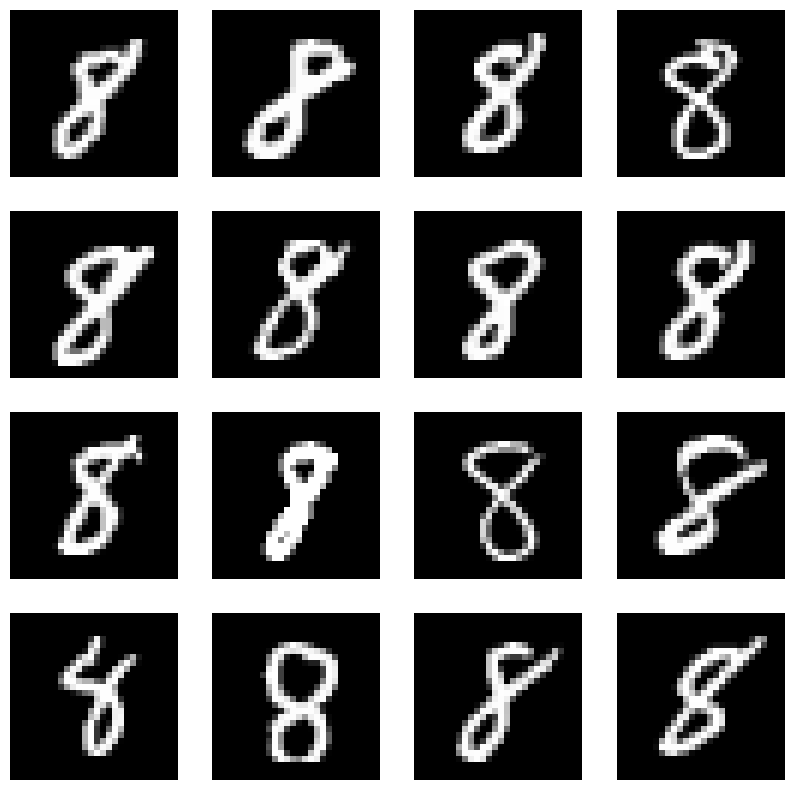

tf.Tensor(
[[0.97153336]
 [0.8682528 ]
 [0.96420485]
 [0.9520798 ]
 [0.9700844 ]
 [0.90510434]
 [0.9608536 ]
 [0.98449695]
 [0.92040277]
 [0.8205673 ]
 [0.8504406 ]
 [0.88278365]
 [0.41281202]
 [0.8887475 ]
 [0.90634936]
 [0.86298555]], shape=(16, 1), dtype=float32)


In [ ]:
print_image_sample(noisify(images_of_target[:16], 0))
print(tf.sigmoid(discriminator(images_of_target[:16])))

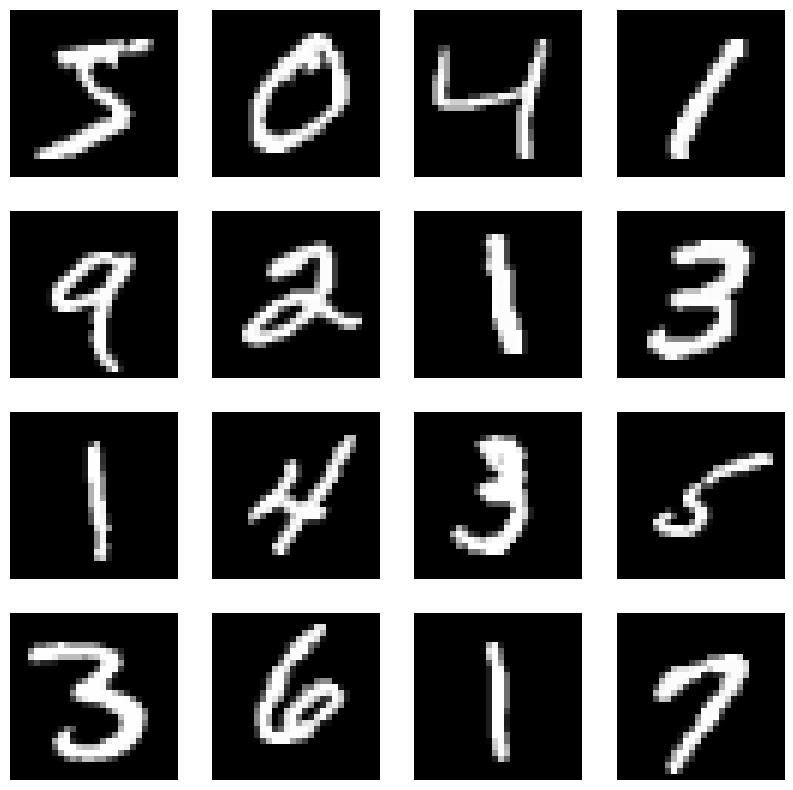

tf.Tensor(
[[0.05339272]
 [0.00971282]
 [0.00958136]
 [0.48083043]
 [0.34559682]
 [0.57327545]
 [0.19094017]
 [0.3342823 ]
 [0.2498089 ]
 [0.05236363]
 [0.21639939]
 [0.22484137]
 [0.09962499]
 [0.05332569]
 [0.40479288]
 [0.01612917]], shape=(16, 1), dtype=float32)


In [ ]:
print_image_sample(noisify(images_of_others[:16], 0))
print(tf.sigmoid(discriminator(images_of_others[:16])))

Iters:  tf.Tensor(70, shape=(), dtype=int32)


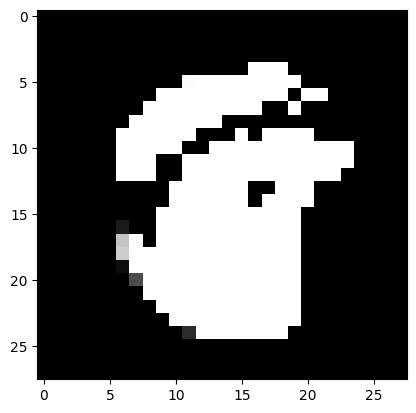

(1, 28, 28, 16)
tf.Tensor([[0.03977384]], shape=(1, 1), dtype=float32)


In [ ]:
image = noisify(generate_and_save_images(generator,0,seed)[None,...], 0)
# print_image_sample(image[..., None])

print(tf.sigmoid(discriminator(image)))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
import imageio
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'

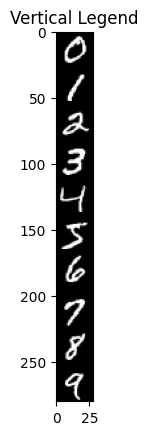

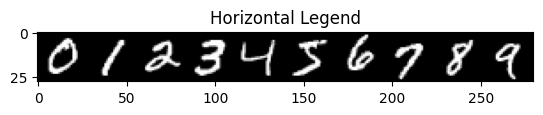

In [ ]:
# @title Generate train/test set from MNIST.

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = 1 * ((train_images) / 255)
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Separate images of '1' and other digits
images_of_target = train_images[train_labels == TARGET_DIGIT]
images_of_others = train_images[train_labels != TARGET_DIGIT]

# Downsample the 'other digits' dataset to match the size of '1s' dataset
size_of_targets = images_of_target.shape[0]
downsampled_images_of_others = images_of_others[:size_of_targets]

# Combine and shuffle the datasets
combined_images = np.concatenate((images_of_target, downsampled_images_of_others), axis=0)
combined_labels = np.concatenate((np.ones(size_of_targets), np.zeros(size_of_targets)), axis=0)

# # Shuffle the combined dataset
# shuffled_indices = np.random.permutation(combined_images.shape[0])
# combined_images = combined_images[shuffled_indices]
# combined_labels = combined_labels[shuffled_indices]

# Create the TensorFlow dataset
x_train = tf.data.Dataset.from_tensor_slices((combined_images, combined_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# take a target image
target_image = images_of_target[5]



def to_ten_dim_label(x, y):
    # x shape is [b, r, c]
    # y shape is [b]
    y_res = np.zeros(list(x.shape) + [10])
    y_expanded = np.broadcast_to(y, x.T.shape).T
    y_res[x >= 0.1, y_expanded[x >= 0.1]] = 1.0
    return y_res.astype(np.float32)

y_train_pic = to_ten_dim_label(train_images, train_labels)

def find_bw_legend(x_set, y_set, orientation="vertical"):
    result_x = []
    for i in range(10):
        for x, y in zip(x_set, y_set):
            if y == i:
                result_x.append(x)
                break
    assert len(result_x) == 10

    if orientation == "vertical":
        result_x = np.concatenate(result_x, axis=0)
    else:
        result_x = np.concatenate(result_x, axis=1)

    return result_x

# Create vertical and horizontal black and white legends
bw_legend_vertical = find_bw_legend(train_images, train_labels, orientation="vertical")
bw_legend_horizontal = find_bw_legend(train_images, train_labels, orientation="horizontal")

# Show the legend using matplotlib or some other library of your choice
import matplotlib.pyplot as plt

plt.imshow(bw_legend_vertical, cmap='gray')
plt.title('Vertical Legend')
plt.show()

plt.imshow(bw_legend_horizontal, cmap='gray')
plt.title('Horizontal Legend')
plt.show()


In [ ]:
#@markdown ### Model configuration
#@markdown These options configure the model to be used and train in this
#@markdown notebook. Please refer to the article for more information.
CHANNEL_N = 16 # Number of CA state channels
CELL_FIRE_RATE = 0.5

EXPERIMENT_TYPE = "Growing" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch





In [ ]:
#@title CA model and utils


def to_greyscale(x):
    return tf.clip_by_value(x[..., 0:1], 0.0, 1.0)

def get_living_mask(x):
    alpha = x[:, :, :, 0:1]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1



class CustomInitializer(Initializer):
    def __init__(self, mean=0.0, stddev=0.01):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, shape, dtype=np.float32):
        return tf.random.normal(shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

In [ ]:
class build_generator(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE, l2_reg = 0):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        self.custom_init = CustomInitializer(mean=0) #was 0.008

        self.perceive = tf.keras.Sequential([
            Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
        ])

        self.dmodel = tf.keras.Sequential([
            Conv2D(80, 1, activation=tf.nn.relu, kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
            Conv2D(self.channel_n, 1, activation=None,
                kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
        ])

        self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

    def reinitialize_weights(self):
        for layer in self.dmodel.layers:
            if hasattr(layer, 'kernel_initializer'):
                layer.kernel.assign(self.custom_init(layer.kernel.shape))
            if hasattr(layer, 'bias_initializer') and layer.use_bias:
                layer.bias.assign(self.custom_init(layer.bias.shape))

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        pre_life_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y)*step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

# TODO reimplement the original training and use sigmoid
# TODO then use this as a warm start

        return x * tf.cast(life_mask, tf.float32)


build_generator().dmodel.summary()

Model: "sequential_228"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_442 (Conv2D)         (1, 3, 3, 80)             6480      
                                                                 
 conv2d_443 (Conv2D)         (1, 3, 3, 16)             1296      
                                                                 
Total params: 7776 (30.38 KB)
Trainable params: 7776 (30.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


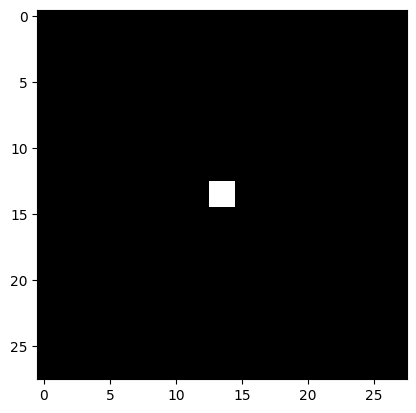

In [ ]:
#@title Lets generate an image! (basic testing that the generator works, with animation)

generator = build_generator()

def animate_ca(generator, h=1, w=1):
    x = make_seed()

    for i in range(1):
        x = generator(x, training=False)
        plt.imshow(to_greyscale(x)[0, :, :, 0], cmap='gray')
        plt.show()
        # print(x[0,:,:,0].numpy().max())

    return x

x = animate_ca(generator)

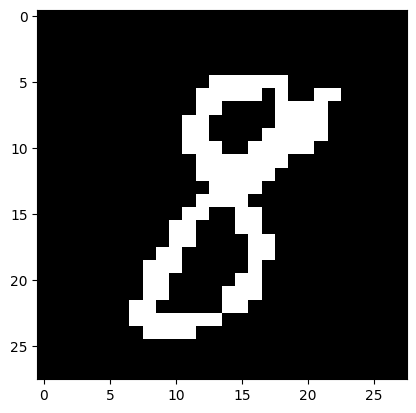

In [ ]:
rounded_target_image = tf.where(target_image > 0.5, 1.0, 0.0)

plt.imshow(rounded_target_image[:, :, :] * 127.5 + 127.5, cmap='gray')

Pretrain the generator

In [ ]:
#@title Reimplement the original training architechture to learn a single exact digit!

#@title Initialize Training { vertical-output: true}

h = 28
w = 28
seeds = make_seed() 

def loss_f(x):
  return tf.reduce_mean(tf.square(to_greyscale(x)-rounded_target_image), [-2, -3, -1])

ca = build_generator()

loss_log = []

lr = 2e-4
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.legacy.Adam(lr_sched)

loss0 = loss_f(seed).numpy()

!mkdir -p train_log && rm -f train_log/*

23467.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
zsh:1: no matches found: train_log/*


Iters:  tf.Tensor(70, shape=(), dtype=int32)


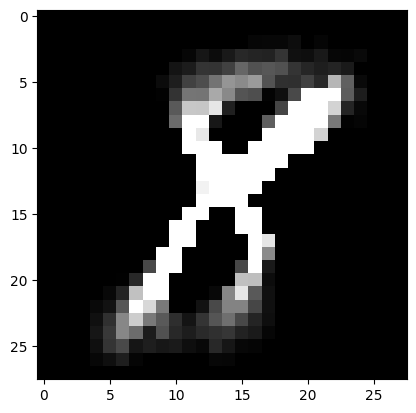

(1, 28, 28, 16)
Epoch 1501, Loss: 0.0260


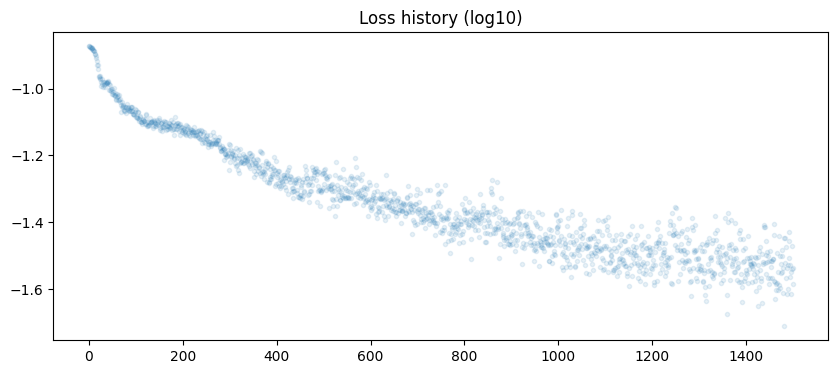

 step: 1501, log10(loss): -1.585

In [ ]:
#@title Original Training Loop {vertical-output: false}

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()

@tf.function
def train_step(x):
  iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x))
    reg_losses = tf.add_n(ca.dmodel.losses)
    total_loss = loss + reg_losses
  grads = g.gradient(total_loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

if TRAIN_GENERATOR: 
  for i in range(4000+1):

      x0 = np.repeat(seed[None, ...], 1, 0)

      x, loss = train_step(x0)

      step_i = len(loss_log)
      loss_log.append(loss.numpy())

      if step_i%100 == 0:
          clear_output(wait=True)
          if tf.reduce_all(generate_and_save_images(ca,
                                  i + 1,
                                  x0) == 0.0): 
              ca.reinitialize_weights() # restart training if the model collapses
          # Print the losses
          print(f"Epoch {i + 1}, Loss: {loss:.4f}")
          plot_loss(loss_log)

      print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

In [ ]:
if TRAIN_GENERATOR: 
  ca.save_weights(f"ca_{TARGET_DIGIT}.h5")

In [ ]:
ca.load_weights(f"ca_{TARGET_DIGIT}.h5")

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def print_image_sample(images): 
    plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

def noisify(images, noise_factor):

    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise
    # Clip the values to be between 0 and 1
    noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0.0, clip_value_max=1.0)
    return noisy_images


In [ ]:
def add_noise_to_weights(model, noise_level=0.01):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Check if the layer has weights
            noisy_weights = [w + noise_level * np.random.randn(*w.shape) for w in weights]
            layer.set_weights(noisy_weights)

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    # return -tf.reduce_mean(fake_output) # WGAN
    return cross_entropy(tf.ones_like(fake_output), fake_output) # Normal cross entropy

def discriminator_loss(real_output, real_labels, fake_output):

    # return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    # real_targets = tf.where(real_labels == TARGET_DIGIT, tf.ones_like(real_labels), tf.zeros_like(real_labels))
    # real_loss = cross_entropy(real_targets, real_output)
    # return real_loss

    if WGAN:
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = wasserstein_loss(real_targets, real_output)
        # return real_loss
        fake_loss = wasserstein_loss(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss * 0 + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss
    else: 
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = cross_entropy(real_targets, real_output)
        # return real_loss
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss * 0 + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss


if TRAIN_DISCRIMINATOR:
    EPOCHS = 1000
    num_examples_to_generate = BATCH_SIZE


    h = 28
    w = 28
    seed = make_seed(1, height = 1, width = 1)

    generator = build_generator()
    discriminator = build_discriminator()

    generator.set_weights(ca.get_weights())

    g_loss_log = []
    d_loss_log = []

    loss0 = generator_loss(seed).numpy()
    !mkdir -p train_log && rm -f train_log/*

    noise_factor = 0
    lr_gen = 2e-50
    lr_disc = 1e-4

    lr_sched_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [2000], [lr_gen, lr_gen * 0.1])
    lr_sched_disc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [2000], [lr_disc, lr_disc * 0.1])

    # Optimizers
    generator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_gen)
    discriminator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_disc)

    train(x_train, EPOCHS)

In [ ]:
#@title Initialize Training

def generator_loss(fake_output):
    # return -tf.reduce_mean(fake_output) # WGAN
    if WGAN: 
        wgan_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)
        l2_loss = tf.add_n(ca.dmodel.losses)
        return wgan_loss + l2_loss
    else: 
        cross_entropy_loss = cross_entropy(tf.ones_like(fake_output), fake_output) # Normal cross entropy
        l2_loss = tf.add_n(ca.dmodel.losses)
        return cross_entropy_loss + l2_loss

def discriminator_loss(real_output, real_labels, fake_output):

    if WGAN:
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = wasserstein_loss(real_targets, real_output)
        # return real_loss
        fake_loss = wasserstein_loss(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss * BATCH_SIZE + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss
    else: 
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = cross_entropy(real_targets, real_output)
        # return real_loss
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss

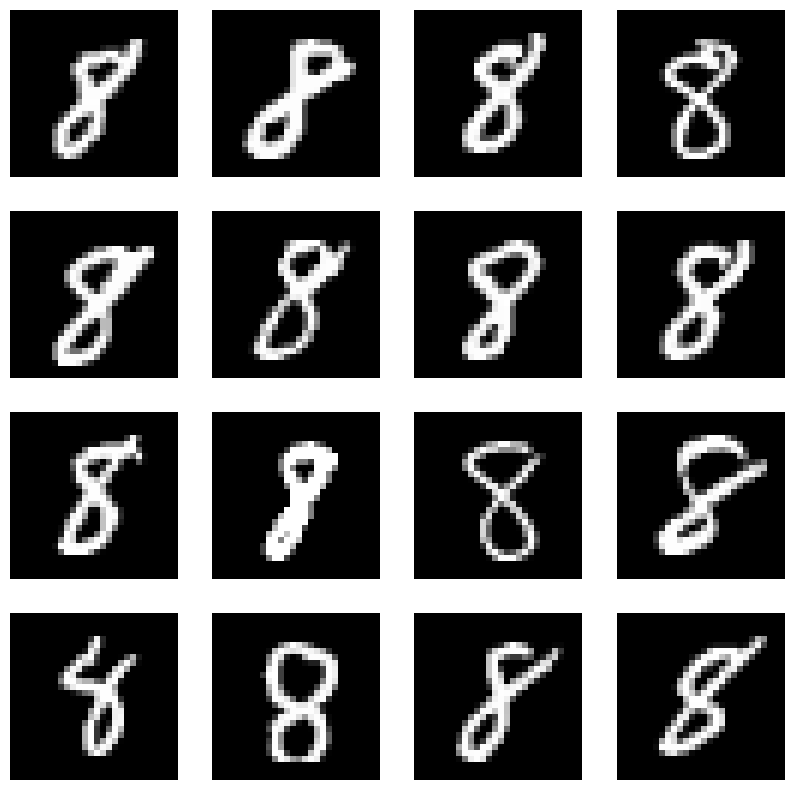

tf.Tensor(
[[0.97153336]
 [0.8682528 ]
 [0.96420485]
 [0.9520798 ]
 [0.9700844 ]
 [0.90510434]
 [0.9608536 ]
 [0.98449695]
 [0.92040277]
 [0.8205673 ]
 [0.8504406 ]
 [0.88278365]
 [0.41281202]
 [0.8887475 ]
 [0.90634936]
 [0.86298555]], shape=(16, 1), dtype=float32)


In [ ]:
print_image_sample(noisify(images_of_target[:16], 0))
print(tf.sigmoid(discriminator(images_of_target[:16])))

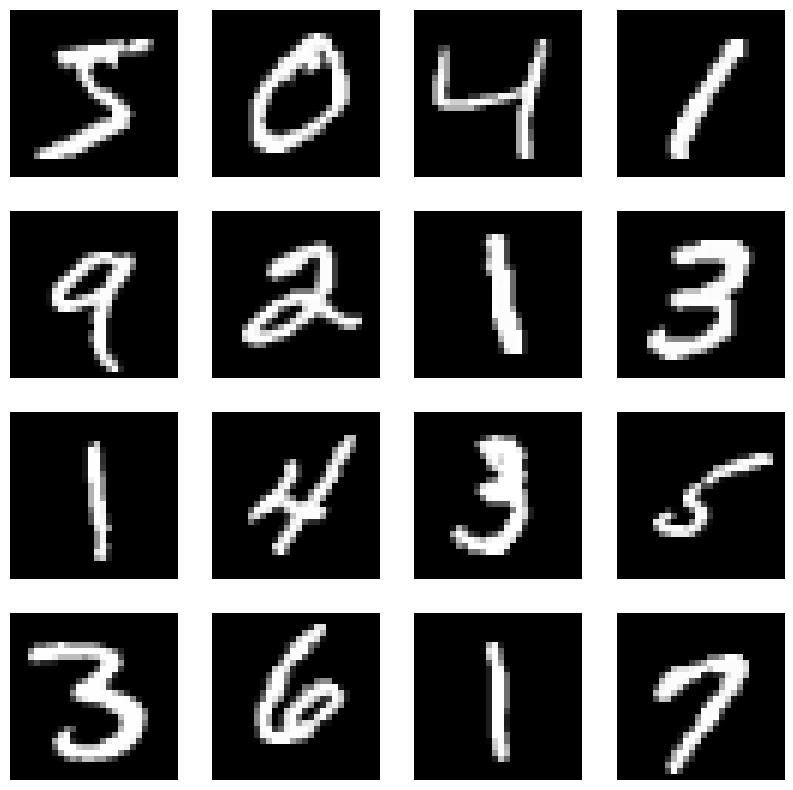

tf.Tensor(
[[0.05339272]
 [0.00971282]
 [0.00958136]
 [0.48083043]
 [0.34559682]
 [0.57327545]
 [0.19094017]
 [0.3342823 ]
 [0.2498089 ]
 [0.05236363]
 [0.21639939]
 [0.22484137]
 [0.09962499]
 [0.05332569]
 [0.40479288]
 [0.01612917]], shape=(16, 1), dtype=float32)


In [ ]:
print_image_sample(noisify(images_of_others[:16], 0))
print(tf.sigmoid(discriminator(images_of_others[:16])))

Iters:  tf.Tensor(70, shape=(), dtype=int32)


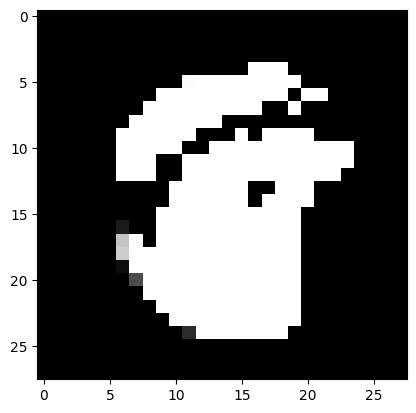

(1, 28, 28, 16)
tf.Tensor([[0.03977384]], shape=(1, 1), dtype=float32)


In [ ]:
image = noisify(generate_and_save_images(generator,0,seed)[None,...], 0)
# print_image_sample(image[..., None])

print(tf.sigmoid(discriminator(image)))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
import imageio
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'